In [80]:
import numpy as np
import pandas as pd

In [81]:
# Чтение из файла JSON в DataFrame
processed_df = pd.read_json("Datasets/processed_dataset.json")
corpus = processed_df['text'].values
ratings = processed_df['rating'].values

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

MAX_FEATURES = 1500

vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, min_df=3, max_df=0.6)

x = vectorizer.fit_transform(corpus).toarray()
y = ratings

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
X_validation, y_validation = X_test[0:len(X_test)//2], y_test[0:len(y_test)//2]

In [83]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [84]:
X_train_tensor = torch.from_numpy(X_train).float()
X_validation_tensor = torch.from_numpy(X_validation).float()
X_test_tensor = torch.from_numpy(X_test).float()

y_train_tensor = torch.from_numpy(y_train) - 1
y_validation_tensor = torch.from_numpy(y_validation) - 1
y_test_tensor = torch.from_numpy(y_test) - 1

In [85]:
class Linear_model(nn.Module):
    def __init__(self, output_size = 5, hidden_size = 5):
        super(Linear_model, self).__init__()
        self.fc1 = torch.nn.Linear(MAX_FEATURES, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu((self.fc1(x)))
        x = torch.relu((self.fc2(x)))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [86]:
import matplotlib.pyplot as plt
import time

def train(
    model,
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor,
    y_val_tensor,
    optimizer, 
    criterion, 
    epochs = 100, 
    print_process = True
    ):
    
    loss_history = np.zeros(epochs)
    acc_history = np.zeros(epochs)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        
        X_train_tensor = X_train_tensor.to(device)
        y_train_tensor = y_train_tensor.to(device)
        optimizer.zero_grad()
        
        Ypred = model(X_train_tensor).to(device)
        
        loss = criterion(Ypred, y_train_tensor)
        loss_history[epoch] = loss
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            X_val_tensor = X_val_tensor.to(device)
            y_val_tensor = y_val_tensor.to(device)
            
            Ypred_val = model(X_val_tensor).to(device)
            
            accuracy = accuracy_score(y_val_tensor.cpu(), torch.argmax(Ypred_val, dim=1).cpu())
            acc_history[epoch] = accuracy
         
        if print_process:
            print(f"Epoch: {epoch}, loss: {loss.item()}, accuracy: {accuracy}")

    end_time = time.time()
    
    x = np.linspace(1, epochs, epochs)
    
    plt.plot(x, loss_history, label="loss")
    plt.plot(x, acc_history, label="accuracy")

    plt.xlabel('epoch')
    plt.legend()
    
    plt.savefig('Plots/Linear_loss.png')
    
    print(f"Training time: {end_time - start_time} seconds")
    print(f"Loss delta: {loss_history[0] - loss}")
    
def predict(sample, model):
    sample = vectorizer.transform(sample).toarray().to(device)
    prediction = model(torch.from_numpy(sample).float())
    
    return torch.argmax(prediction, dim=1).cpu()

def evaluate(model, X_test_tensor, y_test_tensor):
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    Ypred = model(X_test_tensor)

    accuracy = accuracy_score(y_test_tensor.cpu(), torch.argmax(Ypred, dim=1).cpu())

    return accuracy

Training time: 1.6866674423217773 seconds
Loss delta: 1.683000087738037


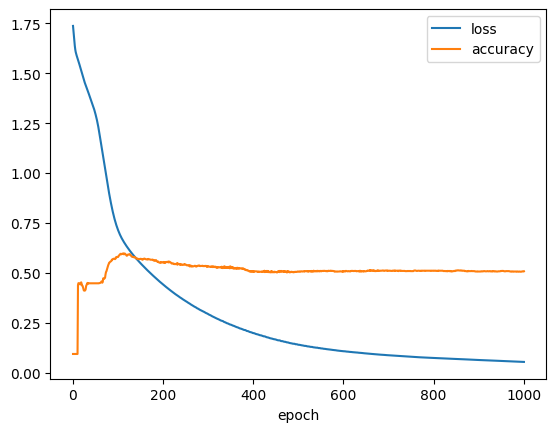

In [94]:
model = Linear_model()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train(
    model,
    X_train_tensor,
    y_train_tensor,
    X_validation_tensor,
    y_validation_tensor,
    optimizer,
    criterion,
    1000,
    False)

torch.save(model.state_dict(), 'Linear_model.pth')

In [95]:
evaluate(model, X_test_tensor, y_test_tensor)

0.492